0.03630186035512135 0.06293328914799041


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: ComplexWarning: Casting complex values to real discards the imaginary part


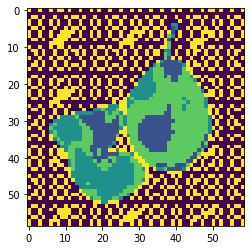

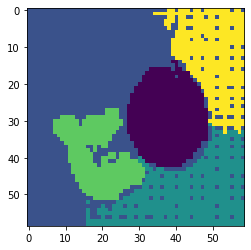

In [8]:
import numpy as np
import matplotlib.image as img
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import math
from sklearn.cluster import KMeans

def searchSimilarity(img):

    # get the width (w), height (h), and # of colors (c) from the image
    [h, w, c] = np.array(img).shape
    
    N = w*h
    
    # those lists will be used to store a sparse matrix S
    li = []
    lj = []
    lv = []
    deg = np.zeros(N)
    mean = 0
    std = 0

    # Here we use a vector to represent an image.
    # Each pixel is an element, so the vector length l = w*h.
    # We will use the row major to define the index of each pixel.
    
    # We need to compute the "similarity" among pixels,
    # and store them in a matrix S, whose size is l*l.
    # But only adjacent pixels are considered to have "location similarity".
    # So the matrix is highly "sparse", which means it has many zeros.
    
    # Therefore, we will use the sparse matrix format to store S.
    # The format we used is called "COOrdinate" (COO), which stores 
    # each nonzero element by (i, j, v), the index (i,j) and the value v.
    #  
    
    #---------------------------------------------------------
    def computeSim(i1, j1, i2, j2):
        # v1 and v2 are vectors of size = 3.
        d = img[i1, j1, :]-img[i2, j2, :]
        v = np.linalg.norm(d)
        return v
    
    def insert(i, j , v):
        # insert the index (i,j) (j,i) and the value v to the matrix
        nonlocal mean, std
        li.append(i)
        lj.append(j)
        lv.append(v)
        li.append(j)
        lj.append(i)
        lv.append(v)
        mean = mean + v
        std = std + v*v
    
    #---------------------------------------------------------
    for h_idx in range(h):
        for w_idx in range(w):
            i = h_idx*h + w_idx  # source 
            # down
            if (h_idx<h-1):      
                j = i + w      # destination
                v = computeSim(h_idx, w_idx, h_idx+1, w_idx)
                insert(i, j, v)
                
            # right
            if (w_idx < w-1):      
                j = i + 1      # destination
                v = computeSim(h_idx, w_idx, h_idx, w_idx+1)
                insert(i, j, v)

    # construct the sparse matrix
    sz = len(li)
    mean = mean / sz
    std = math.sqrt(std/sz - mean*mean)
    print(mean, std)
    
    for i in range(sz):
        lv[i] = -math.exp(-lv[i]*2/std)
        deg[li[i]] = deg[li[i]] - lv[i]
        
    for i in range(N):
        li.append(i)
        lj.append(i)
        lv.append(1)
        deg[i] = math.sqrt(deg[i])

    for i in range(sz):
        lv[i] = lv[i]/deg[li[i]]/deg[lj[i]]

    L = sp.coo_matrix((lv, (li,lj)), shape=(N, N))
    
    return L, w, h

# -------- spectral clustering ------------------
def SpectralClustering(image, nCluster):
    ''' the returned values of searchSimilarity are
        L: Laplacian matrix in the COO format
        w, h: the width and height of the image
    '''
    L, w, h = searchSimilarity(image)

    # call scipy.sparse.linalg.eigs to get the smallest eigenvalues 
    # and its corresponding eigenvectors
    m = 5
    vals, vecs = spla.eigs(L, k=m, which='SR')
    min_vecs = np.reshape(vecs, (w*h,m)).astype(float)
    clf = KMeans(n_clusters=nCluster)
    clf.fit(min_vecs)
    img_labels = np.reshape(clf.labels_, (h, w))
    # use the values in eigenvectors as features and call K-means to 
    # cluster pixels
    return img_labels

# -------- Kmeans Clustering --------------------
def KMeansClustering(image, nCluster):
    ''' Use RGB values as features to cluster objects.
    '''
    [h, w, c] = np.array(image).shape
    N = w*h
    img = np.reshape(image, (N, c))
    
    clf = KMeans(n_clusters=nCluster)
    clf.fit(img)
    img_labels = np.reshape(clf.labels_, (h, w))
    return img_labels
    
# -------- main program -------------------------
image = img.imread('pear.png')

nCluster = 5
img1 = KMeansClustering(image, nCluster)
plt.imshow(img1)
plt.figure()
img2 = SpectralClustering(image, nCluster)
plt.imshow(img2)